Pipelines: Mass Total + Source Inversion
========================================

By chaining together two searches this script fits `Interferometer` dataset of a 'galaxy-scale' strong lens, where in the
final model:
.
 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllPowerLaw`.
 - The source galaxy is an `Inversion`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
from utils import fitutil as af
import utils as al
import utils.plot as aplt

/workspace
Working Directory has been set to `/workspace`


2021-10-13 16:55:00,624 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-13 16:55:00,669 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-13 16:55:00,723 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-13 16:55:00,782 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-13 16:55:00,803 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-13 16:55:00,865 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Dataset + Masking__ 

Load the `Interferometer` data, define the visibility and real-space masks and plot them.

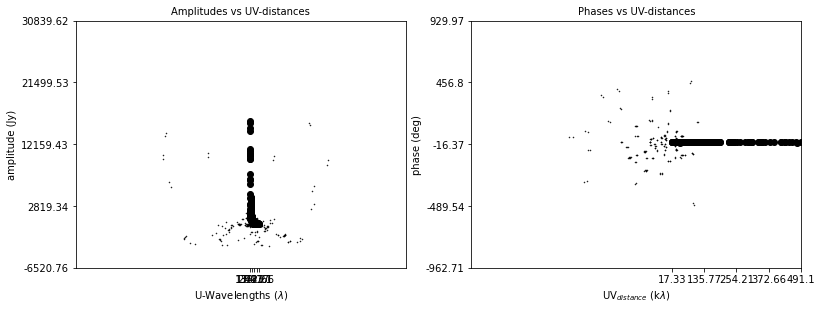

/usr/local/lib/python3.9/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[


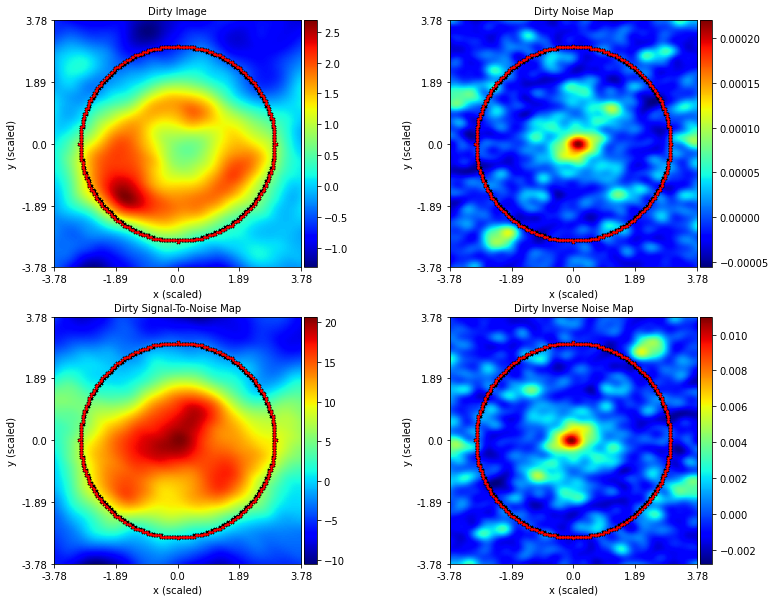

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(151, 151), pixel_scales=0.05, radius=3.0
)

dataset_name = "mass_sie__source_sersic_x2"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)
interferometer = interferometer.apply_settings(
    settings=al.SettingsInterferometer(transformer_class=al.TransformerNUFFT)
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("interferometer", "pipelines")

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [ ]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=al.mp.EllIsothermal,
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=redshift_source, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[1]_mass[sie]_source[parametric]",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisInterferometer(dataset=interferometer)

result_1 = search.fit(model=model, analysis=analysis)

__Model + Search + Analysis + Model-Fit (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [Parameters fixed to 
 results of search 1].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [2 parameters].
 
 - This pixelization is regularized using a `Constant` scheme [1 parameter]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [ ]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=result_1.instance.galaxies.lens.mass,
            shear=result_1.instance.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=al.pix.VoronoiMagnification,
            regularization=al.reg.Constant,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_mass[sie]_source[inversion_initialization]",
    unique_tag=dataset_name,
    nlive=20,
)

analysis = al.AnalysisInterferometer(dataset=interferometer)

result_2 = search.fit(model=model, analysis=analysis)

__Model + Search (Search 3)__

We use the results of searches 1 and 2 to create the lens model fitted in search 3, where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [7 parameters: priors 
 initialized from search 1].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [parameters fixed to results of search 2].
 
 - This pixelization is regularized using a `Constant` scheme [parameters fixed to results of search 2]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [ ]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=result_1.model.galaxies.lens.mass,
            shear=result_1.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=result_2.instance.galaxies.source.pixelization,
            regularization=result_2.instance.galaxies.source.regularization,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[3]_mass[sie]_source[inversion]",
    unique_tag=dataset_name,
    nlive=50,
)

__Positions + Analysis + Model-Fit (Search 3)__

We update the positions and positions threshold using the previous model-fitting result to remove unphysical solutions from the `Inversion` model-fitting.

In [ ]:
settings_lens = al.SettingsLens(
    positions_threshold=result_1.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    positions=result_2.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

result_3 = search.fit(model=model, analysis=analysis)

__Model + Search + Analysis + Model-Fit (Search 4)__

We use the results of searches 2 and 4 to create the lens model fitted in search 4, where:

 - The lens galaxy's total mass distribution is an `EllPowerLaw` and `ExternalShear` [8 parameters: priors 
 initialized from search 3].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [parameters fixed to results of search 2].
 
 - This pixelization is regularized using a `Constant` scheme [parameters fixed to results of search 2]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [ ]:
mass = af.Model(al.mp.EllPowerLaw)
mass.take_attributes(result_3.model.galaxies.lens.mass)

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=mass,
            shear=result_3.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=result_2.instance.galaxies.source.pixelization,
            regularization=result_2.instance.galaxies.source.regularization,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[4]_mass[total]_source[inversion]",
    unique_tag=dataset_name,
    nlive=100,
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer, settings_lens=settings_lens
)

result_4 = search.fit(model=model, analysis=analysis)

Finish.